In [1]:
!pwd

/dli/task/ComParE2022_VecNet/notebooks/DK


In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [3]:
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_1.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_2.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_3.zip?download=1
# !wget https://zenodo.org/record/4904800/files/humbugdb_neurips_2021_4.zip?download=1

In [4]:
# !unzip /content/humbugdb_neurips_2021_1.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_2.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_3.zip?download=1 -d '/content/HumBugDB/data/audio'
# !unzip /content/humbugdb_neurips_2021_4.zip?download=1 -d '/content/HumBugDB/data/audio'

In [5]:
!pip install torch_audiomentations
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
from torch_audiomentations import Compose,AddBackgroundNoise , AddColoredNoise , ApplyImpulseResponse,PeakNormalization,TimeInversion

In [7]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [8]:
# other dependencies
#!pip install timm ipywidgets

In [9]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [10]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [11]:
!pwd

/dli/task/ComParE2022_VecNet/notebooks/DK


In [12]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../../src'))
import config ,config_pytorch
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [13]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [14]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization


In [15]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [16]:
#Global Training variables 
USE_SHORT_AUDIO = True
num_workers=8
pin_memory=True
#train_size = 100
batch_size = 64
test_batch_size = 64
DEBUG = False
if DEBUG:
    batch_size = 4
    test_batch_size = 4
    num_workers=1
    
     

num_epochs = 100

In [17]:
# This function creates 1.92 secs rows of audio in a data frame format
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [18]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]


### Read CSV and get train/test groups

In [19]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,8/9/2016 8:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,1/7/2018 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [20]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"



In [21]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
# other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
# df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [22]:
df.drop(df[df['specie_ind'] == "NULL_VAL"].index, inplace=True)
#other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
#df.loc[other_df_ind,'specie_ind']= other_ind        

At this stage we have all extracted the data with specie information and have encoded the specie encoding in a col = 'specie_ind'

In [23]:
#extracting the TZ and Cup data- this is as per the humbug paper

idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_all = df[idx_multiclass]

In [24]:
df_all.reset_index(inplace=True)

In [25]:
df_all

,index,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,...,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,1879,221103,2.56,IFA_17_24_664.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
1,1880,221111,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
2,1881,221110,2.56,IFA_17_25_665.wav,44100,30-01-20 00:00,mosquito,ma africanus,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,7
3,1882,221149,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
4,1883,221150,2.56,IFA_17_26_666.wav,44100,30-01-20 00:00,mosquito,an arabiensis,Female,f,...,NaN,HBN,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,4546,222615,30.72,IFA_86_39_3439.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2284,4547,222585,25.60,IFA_86_40_3440.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2285,4548,222586,40.90,IFA_87_10_3450.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3
2286,4549,222596,40.90,IFA_87_11_3451.wav,44100,23-08-20 00:00,mosquito,an funestus ss,Female,f,...,NaN,LT,telinga,tascam,Tanzania,Kilombero District,Morogoro,Ifakara,cup,3


### Train-Test split( avoiding sklearn )

In [26]:
np.random.seed(42)
msk_test = np.random.rand(len(df_all)) < 0.2
df_test = df_all[msk_test]
df_train_temp  = df_all[~msk_test]


In [27]:
np.random.seed(42)
msk_train = np.random.rand(len(df_train_temp)) < 0.2
df_val = df_train_temp[msk_train]
df_train  = df_train_temp[~msk_train]

## Let's verify for data leakage by performing an inner-join on id

In [28]:
pd.merge(df_test,df_train, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [29]:
pd.merge(df_test,df_val, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


In [30]:
pd.merge(df_train,df_val, on = 'id', how = 'inner')

,index_x,id,length_x,name_x,sample_rate_x,record_datetime_x,sound_type_x,species_x,gender_x,fed_x,...,age_y,method_y,mic_type_y,device_type_y,country_y,district_y,province_y,place_y,location_type_y,specie_ind_y


We've confirmed that there is no recording that is common in Train,Test,val

### Next, we perform "offsets", spliting each(long) recording into multiple 1.92 secs chunk. 

In [31]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [32]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 32239
length of test offset = 10087
length of val offset = 8692


In [33]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



### Let's check for data leakage in offsets

In [34]:
pd.merge(df_train_offset , df_test_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


In [35]:
pd.merge(df_train_offset , df_val_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


In [36]:
pd.merge(df_test_offset , df_val_offset , on = 'id', how = 'inner')

,index_x,id,offset_x,length_x,specie_ind_x,index_y,offset_y,length_y,specie_ind_y


### At this stage we've a dataframe of recordin ids and each row corresponds to a 1.92 secs recording or shorter


In [37]:
def get_specie_distri(df , classes , type_df = None):
    """This function takes a dataframe and provides a count of each specie class"""
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [38]:
#Class imbalance 
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.32298429 0.56615271 3.6109991  0.61779473 1.98809817 4.24197368
 3.08802682 5.57382434]


Let us now get the class distribution for each of the dataframes- train,test and val

In [39]:
get_specie_distri(df_train_offset , classes , type_df = "train")


DF type = train
i = 0
12477
DF type = train
i = 1
7118
DF type = train
i = 2
1116
DF type = train
i = 3
6523
DF type = train
i = 4
2027
DF type = train
i = 5
950
DF type = train
i = 6
1305
DF type = train
i = 7
723


In [40]:
get_specie_distri(df_val_offset , classes , type_df = "Val")

DF type = Val
i = 0
3613
DF type = Val
i = 1
1994
DF type = Val
i = 2
230
DF type = Val
i = 3
1855
DF type = Val
i = 4
280
DF type = Val
i = 5
228
DF type = Val
i = 6
426
DF type = Val
i = 7
66


In [41]:
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
4356
DF type = test
i = 1
1879
DF type = test
i = 2
439
DF type = test
i = 3
1959
DF type = test
i = 4
507
DF type = test
i = 5
312
DF type = test
i = 6
441
DF type = test
i = 7
194


In [42]:
# This function pads a short-audio tensor with its mean to ensure that it becomes a 1.92 sec long audio equivalent
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [43]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(len(classes)))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [44]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [45]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [46]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [47]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,221103,0,2.56,7
1,1,221111,0,2.56,7
2,2,221110,0,2.56,7
3,3,221149,0,2.56,0
4,4,221144,0,2.56,1


In [48]:
def get_error_df(loader , trained_model, DEBUG = False):
    err_dict = {'id': None,
               'label': None,
               'offset':None,
               'y_hat':None}
    model = trained_model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        all_wav_id = []
        all_offset = []
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y,offset,wav_id) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                print("y = " + str(y))
                print("offset = " + str(offset))
                print("wav_id = " + str(wav_id))
                
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
            all_y.append(y.cpu().detach())
            all_wav_id.append(wav_id.cpu().detach())
            all_offset.append(offset.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y).numpy()
        all_y_pred = torch.cat(all_y_pred)
        all_wav_id = torch.cat(all_wav_id)
        all_offset = torch.cat(all_offset)
        
        err_dict['id'] = all_wav_id
        err_dict['label'] = all_y
        err_dict['offset'] = all_offset
        err_dict['y_hat'] = all_y_pred
        df_err = pd.DataFrame.from_dict(err_dict)
        df_err_uniq = df_err[df_err['label']!= df_err['y_hat']]
        df_err_uniq.sort_values(by=['id','offset'])

        
        
        
        if DEBUG:
            print("inside error ....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        #test_loss = test_loss/len(test_loader)
        #test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return df_err_uniq

In [49]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred

In [50]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            overrun_counter = -1
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir,  checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir,  checkpoint_name)) 
            print("Now printing classification rport... ")
            print("********************************")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            # at times output is not getting printed. Could be due to multi threading and hence adding sleep
            time.sleep(2)
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            time.sleep(2)
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [51]:
# from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


# apply_augmentation = Compose(transforms=[AddColoredNoise(p = 1) ,TimeInversion( p = 1) ,PolarityInversion(p = 1)])

# #apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [52]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
                   
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
       # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("idx = " + str(idx))
            print("offset = " + str(offset))
            print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [53]:
class MozErrAnalysisDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'],offset, self.audio_df.loc[idx]['id'])


In [54]:
class MozTestDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("idx = " + str(idx))
            print("shape of x post augmentation = " + str(x.shape))
            print("offset = " + str(offset))
            print("from get_item of train, returning  x of shape = " +str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [55]:
def apply_aug(x,rate):
        apply_augmentation = Compose(transforms=[AddColoredNoise(p = .75) ,TimeInversion( p = .75) ,PolarityInversion(p = .25)])
        aug_audio = apply_augmentation(x,sample_rate = rate)
        return(aug_audio)
    

class augment_audio(nn.Module):
    """This is a class to introduce randomness in the data.
    We implement it as a layer in the NN to ensure that it learns from the propertis of the data"""
    def __init__(self , trainable = True, sample_rate = config.rate):
        super().__init__()
        self.trainable = trainable
        self.rate = sample_rate
            
    def forward(self, x):
        x = x.unsqueeze(dim = 1)
           
        if self.trainable:
            x = apply_aug(x , self.rate)
        else:
            x = x
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x.squeeze(dim = 1)

In [56]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=8, in_chans=1, 
                        drop_path_rate=0.2, global_pool='max',
                        drop_rate=0.2)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
        
    def forward(self, x):
        # first compute spectrogram
        if DEBUG:
            print("input shape that goes for augmentation = " + str(x.squeeze().shape))
        spec = self.augment_layer(x.squeeze())
        if DEBUG:
            print("Out put of augment and input shape that goes for STFT = " + str(spec.shape))
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        if DEBUG:
            print("Out put of STFT and input shape that goes for PCEN = " + str(spec.shape))
        spec = self.pcen_layer(spec)
        if DEBUG:
            print("Out put of PCEN and input shape that goes for NORM = " + str(spec.shape))
        spec = self.norm_layer(spec)
        
        if DEBUG:
            print("Out put of NORM and input shape that goes for time mask = " + str(spec.shape))
        spec = self.timeMasking(spec)
        if DEBUG:
            print("Out put of timemask and input shape that goes for freq mask = " + str(spec.shape))
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        if DEBUG:
            print("Final shape that goes to backbone = " + str(x.shape))
        
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [57]:
print(config.data_dir)
train_dataset = MozTrainDataset(df_train_offset,  config.data_dir, min_length , transform = None)
val_dataset = MozTestDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozTestDataset(df_test_offset,  config.data_dir, min_length)
error_dataset = MozErrAnalysisDataset(df_val_offset,  config.data_dir, min_length = config.min_duration)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )

error_loader = torch.utils.data.DataLoader(
        error_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


../../data/audio


In [58]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 32239
Length of train loader = 504


In [59]:
# train_itr = iter(train_loader)
# a,b = train_itr.next()
# print(a.shape)
# print(b)

In [60]:
# spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
#                               window='hann', freq_scale='linear', center=True, pad_mode='reflect',
#                            sr=config.rate, output_format="Magnitude", trainable=True,)
# x = spec_layer(a)

In [61]:
#test_mod = Model('convnext_small',224)



In [62]:
# test_mod(a)


## Training

In [63]:
def load_model(filepath, model=Model('convnext_small',224)):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0785 seconds


sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.0856 seconds
Filepath = ../../models/model_e15_2022_09_30_03_47_23.pth
model = Model(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Drop

  0%|          | 0/504 [00:00<?, ?it/s]

epoch = 0batch = 0 of 504duraation = 0.058877766132354736
epoch = 0batch = 200 of 504duraation = 1.8957700570424398
epoch = 0batch = 400 of 504duraation = 3.7006539662679034
Saving model to: ../../models/model_e0_2022_09_30_04_47_29.pth
Now printing classification rport... 
********************************
                       precision    recall  f1-score   support

        an arabiensis       0.70      0.76      0.73      4356
culex pipiens complex       0.51      0.59      0.55      1879
           ae aegypti       0.60      0.33      0.43       439
       an funestus ss       0.60      0.54      0.57      1959
         an squamosus       0.28      0.20      0.23       507
          an coustani       0.39      0.34      0.36       312
         ma uniformis       0.32      0.27      0.29       441
         ma africanus       0.39      0.30      0.34       194

             accuracy                           0.60     10087
            macro avg       0.47      0.42      0.44     100

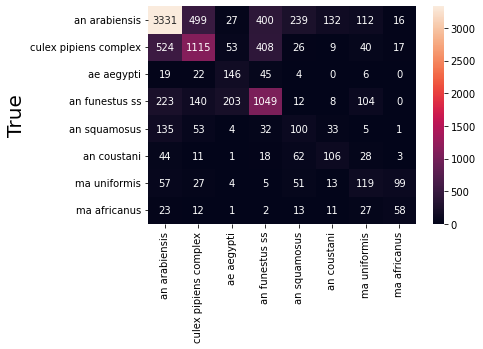

Epoch: 0, Train Loss: 0.07883973, Train f1: 0.95799037, Val Loss: 0.01126886, Val f1: 0.61618410, overrun_counter -1


  0%|          | 0/504 [00:00<?, ?it/s]

epoch = 1batch = 0 of 504duraation = 0.054430643717447914
epoch = 1batch = 200 of 504duraation = 1.9009079972902934
epoch = 1batch = 400 of 504duraation = 3.7100094318389893
..Overrun....no improvement
Epoch: 1, Train Loss: 0.08012459, Train f1: 0.95671829, Val Loss: 0.01226928, Val f1: 0.59656709, overrun_counter 0


  0%|          | 0/504 [00:00<?, ?it/s]

epoch = 2batch = 0 of 504duraation = 0.0605602224667867
epoch = 2batch = 200 of 504duraation = 1.8975269079208374
epoch = 2batch = 400 of 504duraation = 3.704643023014069
..Overrun....no improvement
Epoch: 2, Train Loss: 0.11191856, Train f1: 0.94389869, Val Loss: 0.01122064, Val f1: 0.60121544, overrun_counter 1


  0%|          | 0/504 [00:00<?, ?it/s]

epoch = 3batch = 0 of 504duraation = 0.05736488103866577


In [ ]:
model =Model('convnext_small',224)
filepath = "../../models/model_e15_2022_09_30_03_47_23.pth"
model_epcoh_15 = load_model(filepath,model)
model, lr_log = train_model(train_loader, val_loader, test_loader,model_epcoh_15, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
import torch
x,b = torchaudio.load("../../data/audio/221529.wav")

In [ ]:
val_dataset_new = MozTestDataset(df_val_offset,  config.data_dir, min_length)
val_loader_new = torch.utils.data.DataLoader(
        val_dataset, batch_size=2,
        num_workers=0, pin_memory=pin_memory  )



In [ ]:
val_iter = iter(val_loader_new)
x1,y1 = val_iter.next()
print(x1.shape)
model = model_epcoh_10
model.to('cuda')
x_g = x1.to('cuda')
model(x_g)

In [ ]:
df_error = df_val_offset
model = model_epcoh_10
model.to('cuda')
model.eval()
for idx,(x,y) in enumerate(val_dataset):
    print(idx)
    print(y)
    x = x.to('cuda').float()
    print("x shape = " +str(x.shape))
    #x_new = x.unsqueeze(dim = 1)
    print("x_new shape = " +str(x_new.shape))
    x_new = x.to('cuda')
    y_pred = model(x_new)['prediction']
    y_pred_cpu = y_pred.cpu().detach()
    preds = torch.argmax(y_pred_cpu, axis = 1)
    df_erroriloc[idx]['y_hat'] = preds
    del x_new
    

    

In [ ]:
x = torch.rand(1,15360)
x = x.unsqueeze(dim = 1)

In [ ]:
df_val_offset.head()
path_temp = "../data/audio/"
for i,row in df_val_offset.iterrows():
    print("i = " +str(i))
    print("id = " + str(int(row['id'])))
    file = str(int(row['id']))+".wav"
    print(file)
    path = path_temp + file
    waveform, inp_rate = torchaudio.load(path)
    if inp_rate != config.rate:
        import torchaudio.transforms as T
        resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
        waveform = resampler(waveform)
    if waveform.shape[1] < config.rate*min_length:
        #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
        f_out = pad_mean(waveform)
    else:
        f = waveform[0]
        f_out = f.unsqueeze(0)
    
    
               

In [ ]:
def get_tensor(df):
    
    path_name = "../data/audio/"
    file = df.loc[idx]['id'])}.wav")
    waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("")
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        
        if DEBUG:
            print("shape of x post augmentation = " + str(x.shape))
            
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        if DEBUG:
            print("returning x of shape ..." + str(x[:,offset:int(offset+config.rate*self.min_length)].shape))
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [ ]:
#Take the model checkpoint as a parameter as input
# read the val df
#get the tensor rep for the offset.
#pass it to the model get add get the prediction.


In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))